<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 08 &mdash; Dynamic Asset Allocation (Three Asset Case)**

&copy; Dr. Yves J. Hilpisch

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

In [1]:
%run assetallocation_pytorch.py

In [2]:
days = 2 * 252

In [3]:
random.seed(100)

In [4]:
# 1 = X, 2 = Y, 3 = Z
investing = Investing('.SPX', '.VIX', 'XAU=', steps=days)

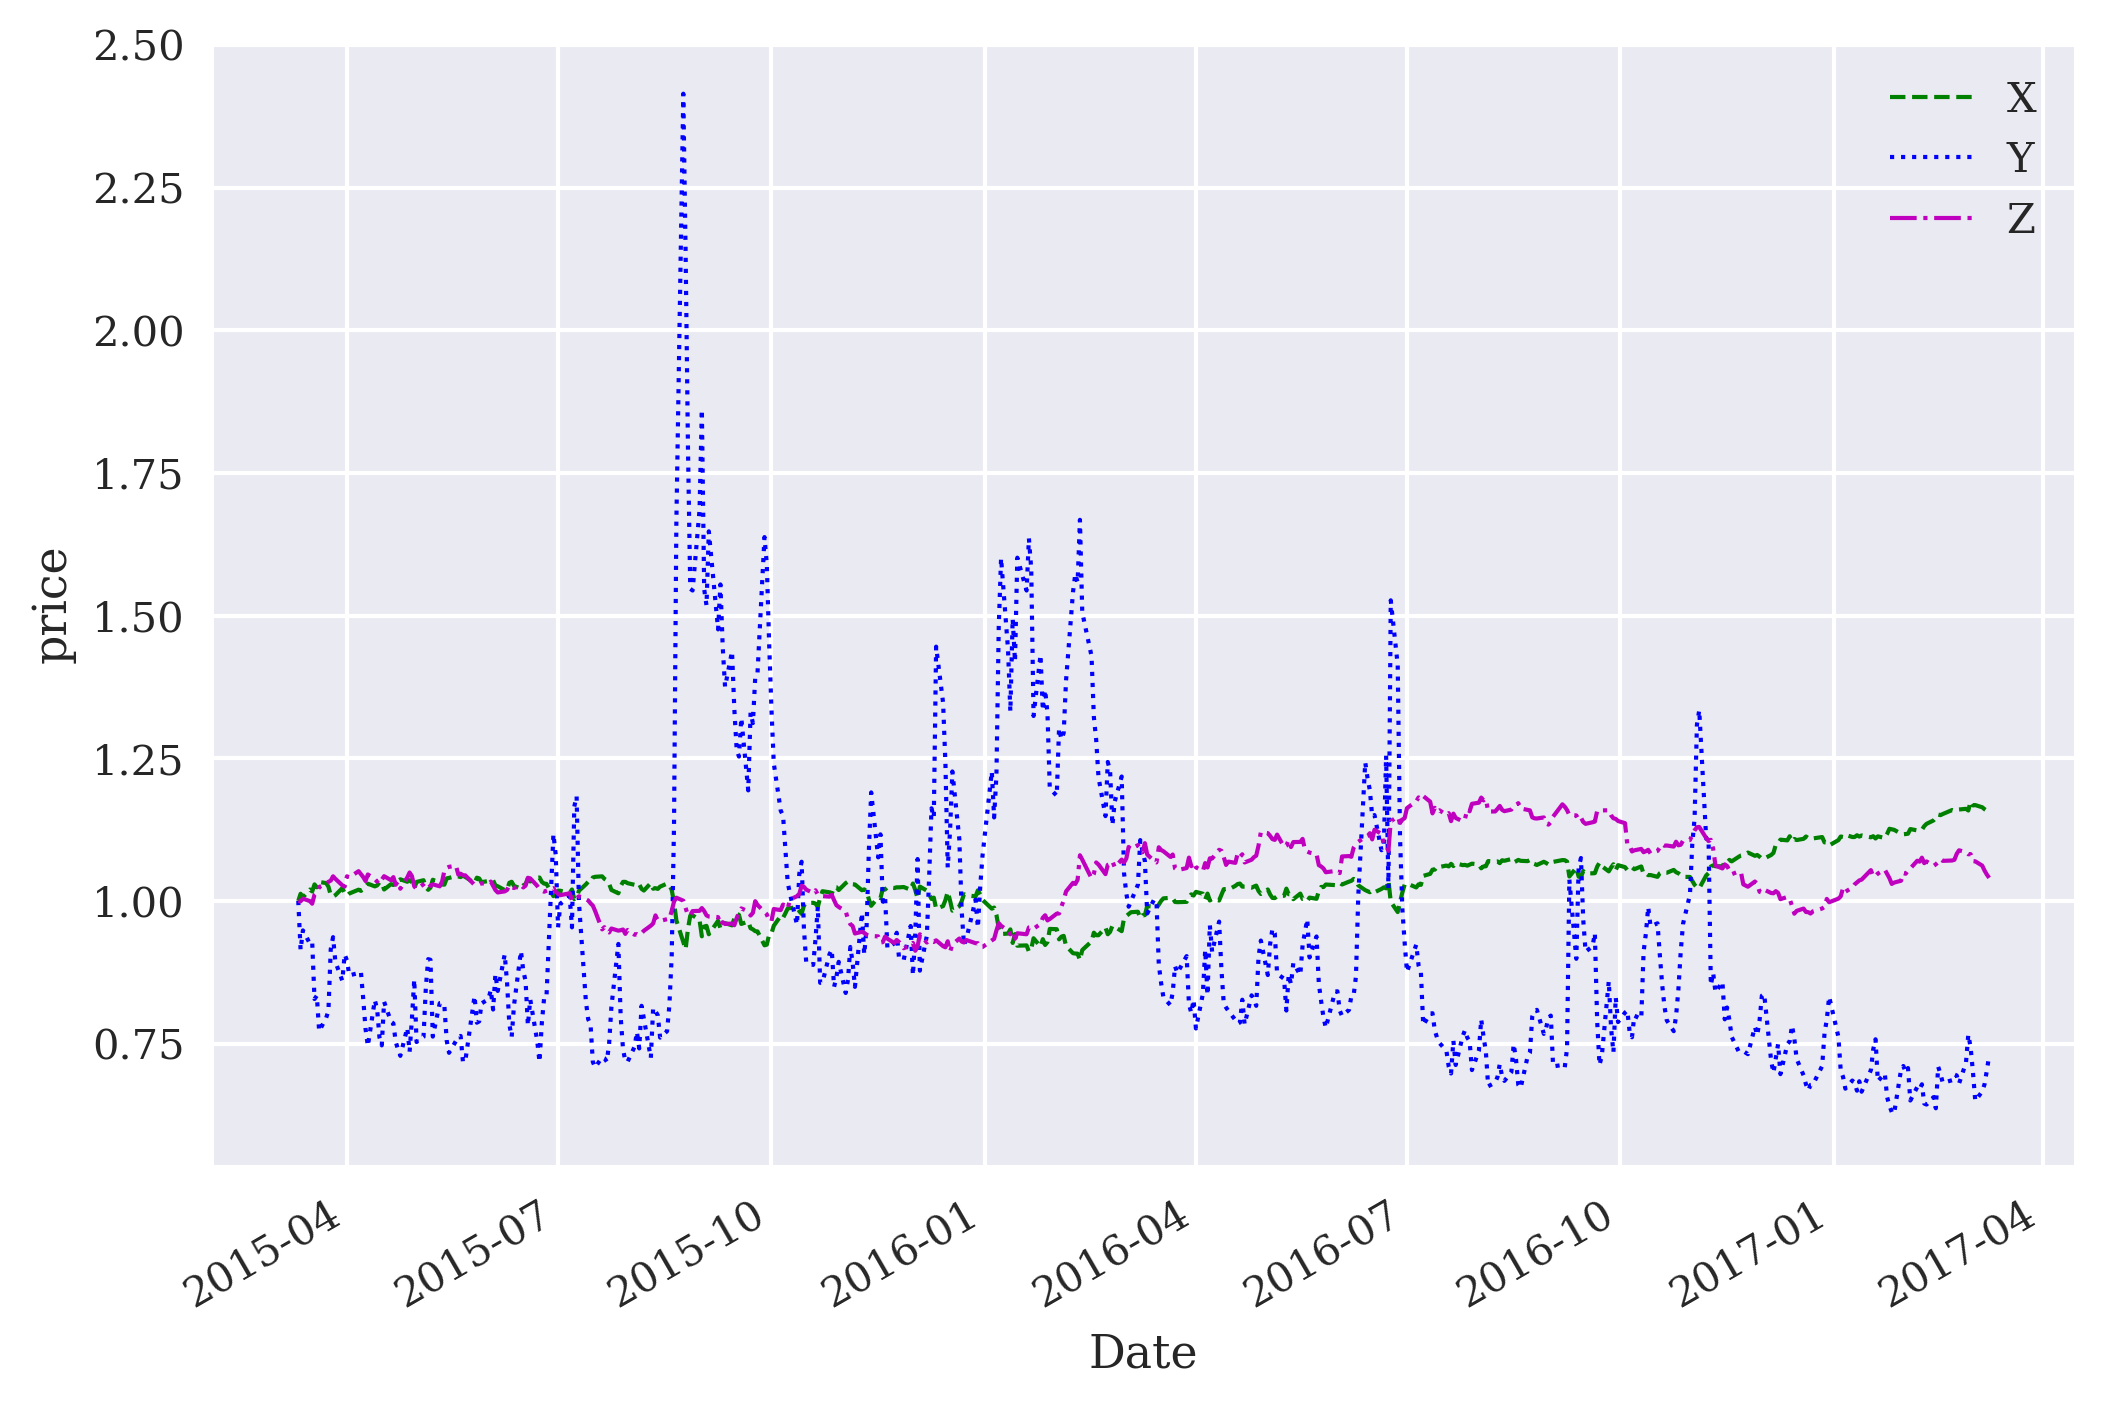

In [5]:
investing.data.plot(lw=1, style=['g--', 'b:', 'm-.'])
plt.ylabel('price');

In [6]:
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)

In [9]:
agent = InvestingAgent('3AC', feature=None, n_features=6,
                     env=investing, hu=128, lr=0.00025)

In [12]:
episodes = 10

In [13]:
%time agent.learn(episodes)

episode=   2 | treward= -1.700 | max= -1.700
episode=   3 | treward= -1.257 | max= -1.257
episode=   4 | treward=  3.471 | max=  3.471
episode=   5 | treward= -2.203 | max=  3.471
episode=   6 | treward=  7.220 | max=  7.220
episode=   7 | treward=  3.378 | max=  7.220
episode=   8 | treward= -2.065 | max=  7.220
episode=   9 | treward=  1.327 | max=  7.220
episode=  10 | treward=  2.606 | max=  7.220
episode=  11 | treward=  3.983 | max=  7.220
CPU times: user 1h 6min 4s, sys: 7min 40s, total: 1h 13min 44s
Wall time: 9min 32s


In [14]:
agent.epsilon

0.09997053357470892

In [15]:
agent.env.portfolios = pd.DataFrame()

In [16]:
%time agent.test(10)

episode=10 | total reward=5.20
CPU times: user 16.8 s, sys: 305 ms, total: 17.1 s
Wall time: 17.7 s


In [17]:
agent.env.portfolios.groupby('e')[
    ['xt', 'yt', 'zt']].mean().mean()

xt    0.437223
yt    0.275162
zt    0.287616
dtype: float64

In [18]:
agent.env.portfolios.groupby('e')[
    ['Xt', 'Yt', 'Zt', 'pv']].last().mean()

Xt    1.181410
Yt    1.049096
Zt    1.077060
pv    1.723568
dtype: float64

In [19]:
def get_r(n):
    r = agent.env.portfolios[
        agent.env.portfolios['e'] == n
        ].set_index('date')
    return r

In [20]:
n = min(agent.env.portfolios['e']) + 1
n

13

In [21]:
r = get_r(n)

In [22]:
r[['xt', 'yt', 'zt']].mean()

xt    0.582921
yt    0.296132
zt    0.120947
dtype: float64

In [23]:
r[['xt', 'yt', 'zt']].std()

xt    0.222339
yt    0.115129
zt    0.131073
dtype: float64

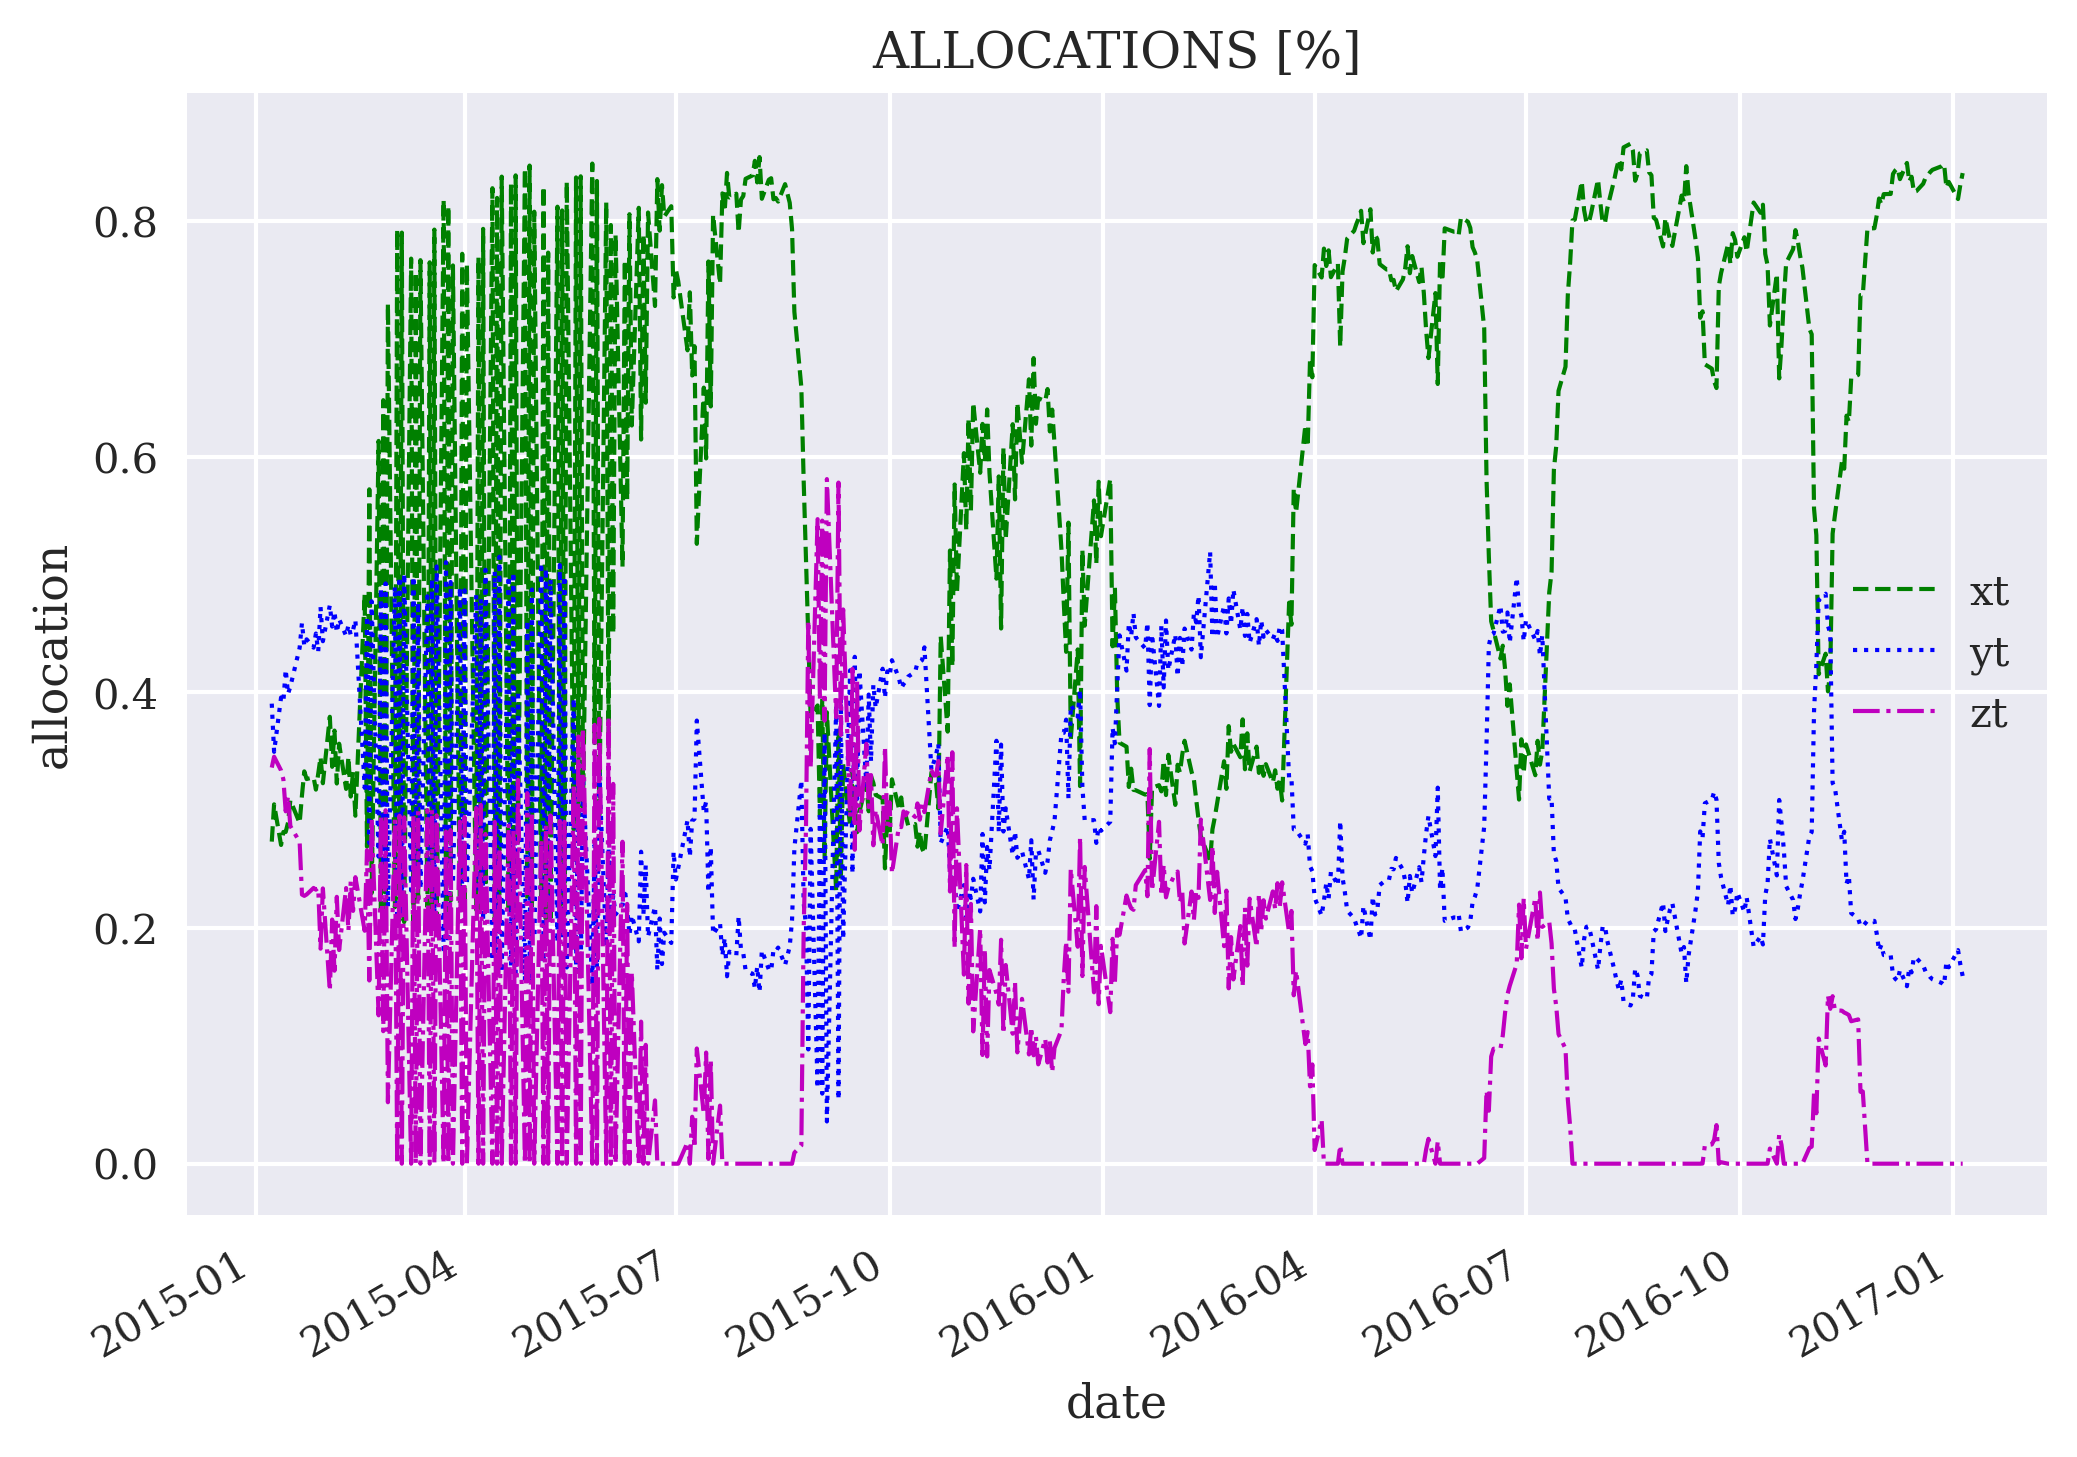

In [24]:
r[['xt', 'yt', 'zt']].plot(
    title='ALLOCATIONS [%]',
    style=['g--', 'b:', 'm-.'],
    lw=1, grid=True)
plt.ylabel('allocation');

In [25]:
cols = ['Xt', 'Yt', 'Zt', 'pv']

In [26]:
sub = r[cols]

In [27]:
rets = sub.iloc[-1] / sub.iloc[0] - 1
rets

Xt    0.120860
Yt   -0.386328
Zt   -0.038552
pv   -0.155926
dtype: float64

In [28]:
stds = sub.pct_change().std() * math.sqrt(252)
stds

Xt    0.142816
Yt    1.352203
Zt    0.149383
pv    0.388747
dtype: float64

In [29]:
rets / stds

Xt    0.846265
Yt   -0.285703
Zt   -0.258076
pv   -0.401099
dtype: float64

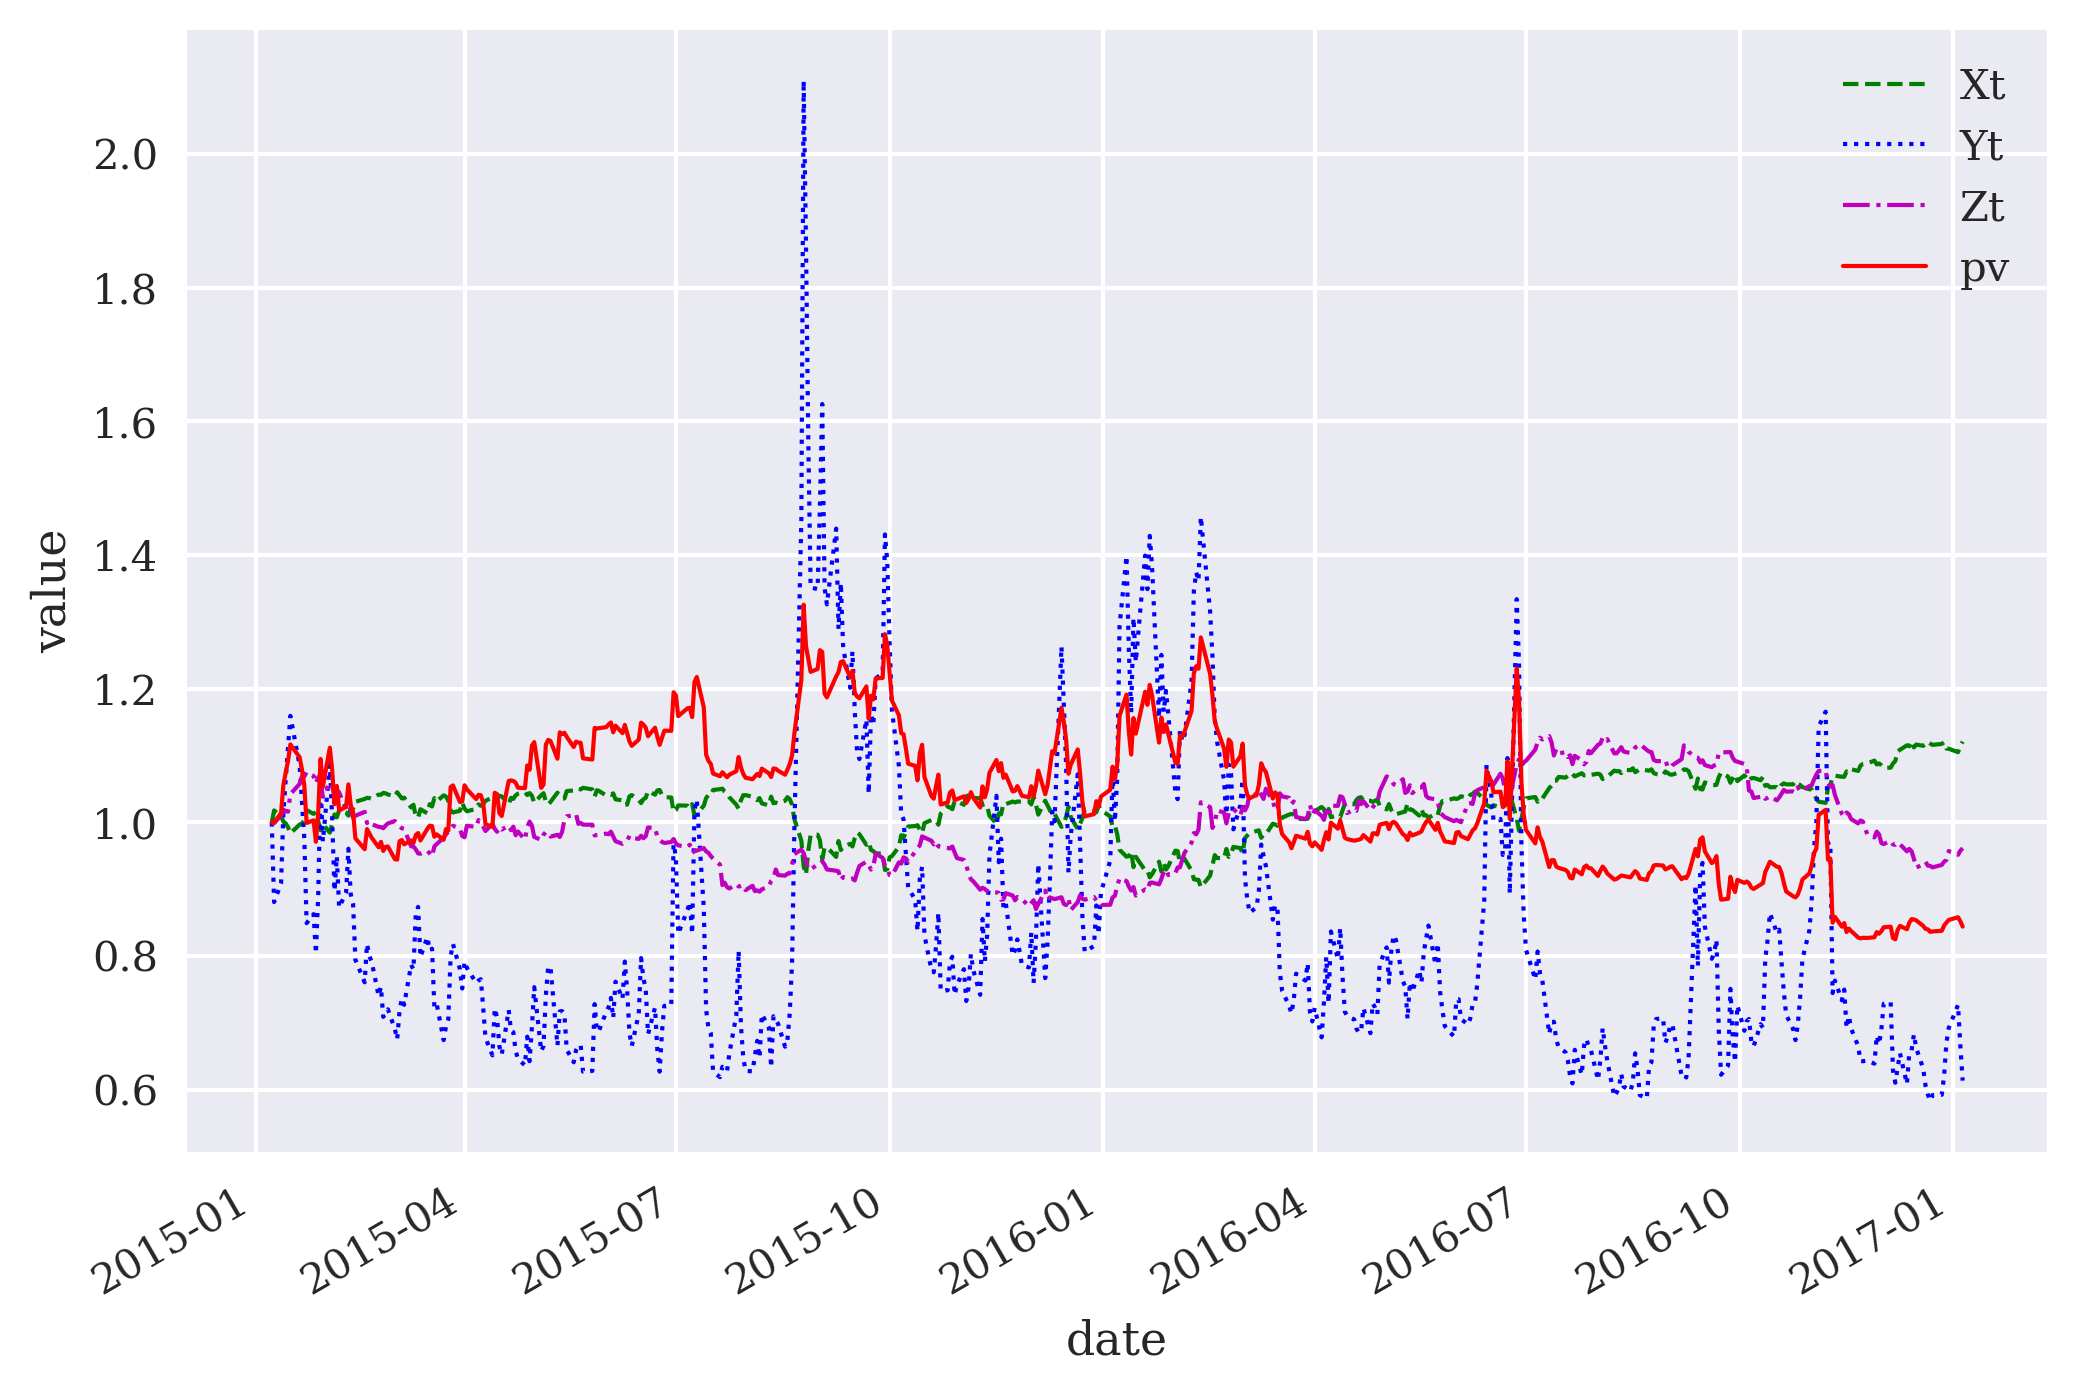

In [30]:
sub.plot(style=['g--', 'b:', 'm-.', 'r-'], lw=1)
plt.ylabel('value');

In [31]:
sharpe = pd.DataFrame()

In [32]:
def calculate_sr():
    for n in set(investing.portfolios['e']):
        r = get_r(n)
        sub = r[cols]
        rets = sub.iloc[-1] / sub.iloc[0] - 1
        stds = sub.pct_change().std() * math.sqrt(252)
        sharpe[n] = rets / stds

In [33]:
calculate_sr()

In [34]:
sharpe.round(2)

,12,13,14,15,16,17,18,19,20,21
Xt,1.34,0.85,0.76,2.22,5.10,0.16,2.82,1.34,0.52,0.17
Yt,0.31,-0.29,-0.22,-0.41,-0.38,0.94,0.07,0.31,-0.06,-0.17
Zt,0.71,-0.26,0.05,1.53,1.56,2.09,-0.89,0.71,-0.15,0.59
pv,3.43,-0.40,1.28,-1.10,-0.41,2.62,1.83,3.43,1.37,3.21


In [35]:
sharpe.mean(axis=1)

Xt    1.527123
Yt    0.009763
Zt    0.593218
pv    1.526757
dtype: float64

In [36]:
((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()

True     6
False    4
Name: count, dtype: int64

## Equally Weighted Portfolio

In [37]:
agent.opt_action = lambda state: np.ones(3) / 3

In [38]:
agent.env.portfolios = pd.DataFrame()

In [39]:
%time agent.test(10)

episode=10 | total reward=2.38
CPU times: user 2.36 s, sys: 44.3 ms, total: 2.4 s
Wall time: 3.96 s


In [40]:
sharpe = pd.DataFrame()

In [41]:
calculate_sr()

In [42]:
sharpe.round(2)

,22,23,24,25,26,27,28,29,30,31
Xt,0.30,-0.18,1.35,0.07,0.41,1.84,2.58,0.88,0.31,0.53
Yt,0.67,0.81,0.06,-0.02,0.20,0.13,0.04,-0.01,-0.15,0.03
Zt,-0.93,1.65,1.23,-0.33,-0.44,0.87,0.34,0.29,0.24,-0.40
pv,1.95,2.72,1.67,1.19,1.52,2.61,1.46,1.21,1.10,1.33


In [43]:
sharpe.mean(axis=1)

Xt    0.808530
Yt    0.177133
Zt    0.251572
pv    1.677120
dtype: float64

In [44]:
((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()

True     9
False    1
Name: count, dtype: int64

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>